In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.interpolate import interpolate_to_grid
from metpy.io import add_station_lat_lon
from metpy.plots import StationPlot
from metpy.units import units
import numpy as np
from siphon.simplewebservice.iastate import IAStateUpperAir 
import xarray as xr

# Grid Interpolation from Point Data
There are times when we have point data but want to make a gridded analysis to be able to have the computer draw contours. While there are many gridded datasets available, sometimes it is best to only use the data you have to create your analysis, especially if you have extra data that were not used in the construction of other gridded products, or you are looking to do a mesoscale analysis over a smaller region. In this notebook we'll use some upperair geopotential height observations over the CONUS available from Iowa State data archives to demonstrate the capabilities in MetPy for gridding up point observations.

## Upperair Observations
There are a couple of different places to retrieve upperair observations from sounding archives. Previously we have used the Wyoming archive to obtain individual stations vertical profiles. Here we will use Siphon and the Iowa State archive to be able to get all of the data available for a given date/time.

In [2]:
# Set date to get observations from
date = datetime(1978, 1, 26, 12)

# Use Siphon Simple Web Service to get all UPA data from IA State archive
df = IAStateUpperAir.request_all_data(date)

In [3]:
df

,pressure,height,temperature,dewpoint,direction,speed,station,time,u_wind,v_wind
0,995.0,172.0,-9.8,-16.7,290.0,NaN,1M1,1978-01-26 12:00:00,NaN,NaN
1,988.0,232.0,-10.0,-17.1,291.0,NaN,1M1,1978-01-26 12:00:00,NaN,NaN
2,950.0,533.0,-12.7,-18.1,294.0,NaN,1M1,1978-01-26 12:00:00,NaN,NaN
3,900.0,943.0,-16.5,-19.6,306.0,NaN,1M1,1978-01-26 12:00:00,NaN,NaN
4,889.0,1035.0,-17.4,-20.0,310.0,NaN,1M1,1978-01-26 12:00:00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7795,140.0,13721.0,-57.6,NaN,NaN,NaN,YNI,1978-01-26 12:00:00,NaN,NaN
7796,133.0,14043.0,-59.4,NaN,NaN,NaN,YNI,1978-01-26 12:00:00,NaN,NaN
7797,125.0,14435.0,-59.1,NaN,272.0,NaN,YNI,1978-01-26 12:00:00,NaN,NaN
7798,113.0,15067.0,-58.6,NaN,NaN,NaN,YNI,1978-01-26 12:00:00,NaN,NaN


## Pre-process Observations
Not all of the needed infromation comes along with our dataset, we need to add station lat/lon information, drop any observations where we don't have any station lat/lon information added and we'll just look at 500-hPa observations in this example.

In [6]:
# Add station lat/lon locations to DataFrame
df = add_station_lat_lon(df)

# Drop any station we don't have a lat/lon for
df = df.dropna(subset=['latitude', 'longitude'])

# Select only 500 hPa data
data_500 = df[df.pressure == 500]
data_500

,pressure,height,temperature,dewpoint,direction,speed,station,time,u_wind,v_wind,latitude,longitude
233,500.0,5640.0,-11.6,-17.0,228.0,NaN,CWOS,1978-01-26 12:00:00,NaN,NaN,43.72,-65.25
277,500.0,5371.0,-31.3,-46.7,319.0,NaN,CWSE,1978-01-26 12:00:00,NaN,NaN,53.53,-114.08
318,500.0,5467.0,-30.3,-39.2,115.0,NaN,CYBK,1978-01-26 12:00:00,NaN,NaN,64.28,-96.07
360,500.0,5450.0,-28.2,-41.6,235.0,NaN,CYCB,1978-01-26 12:00:00,NaN,NaN,69.08,-105.12
411,500.0,5311.0,-32.2,-41.2,272.0,NaN,CYEU,1978-01-26 12:00:00,NaN,NaN,80.0,-85.82
...,...,...,...,...,...,...,...,...,...,...,...,...
5676,500.0,5698.0,-14.6,-33.0,272.0,54.0,KVCT,1978-01-26 12:00:00,53.967105,-1.884573,28.87,-96.93
5712,500.0,5849.0,-7.2,-26.8,230.0,10.0,KVER,1978-01-26 12:00:00,7.660444,6.427876,38.95,-92.68
5748,500.0,5431.0,-11.3,-30.3,209.0,112.0,KWAL,1978-01-26 12:00:00,54.298677,97.957407,37.93,-75.47
5784,500.0,5630.0,-20.9,-22.4,287.0,46.0,KWMC,1978-01-26 12:00:00,43.990019,-13.449098,40.9,-117.8


## Plotting Point Observations with MetPy

MetPy offers the ability to plot surface and upperair observations using a station model. Here we are not going to plot all of the potential variables for an upper-level station model, but demonstrate how to plot the 500-hPa Geopotential Height values. Just like there was a specific plotting class for our SkewT digrams, here we have a station plot class that we'll create using the lat/lon points of the observations we wish to plot. See the link to the documentation below for all of the detailed information.

StationPlot: https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlot.html

Once we set up the station object, we can add observations around the station model using cardinal directions ('N', 'S', 'E', 'W', 'NE', 'SE', 'SW', 'NW', etc.) and a center location ('C'). And we are plotting a numeric parameter, so we'll use the `plot_parameter` method off of our station object.

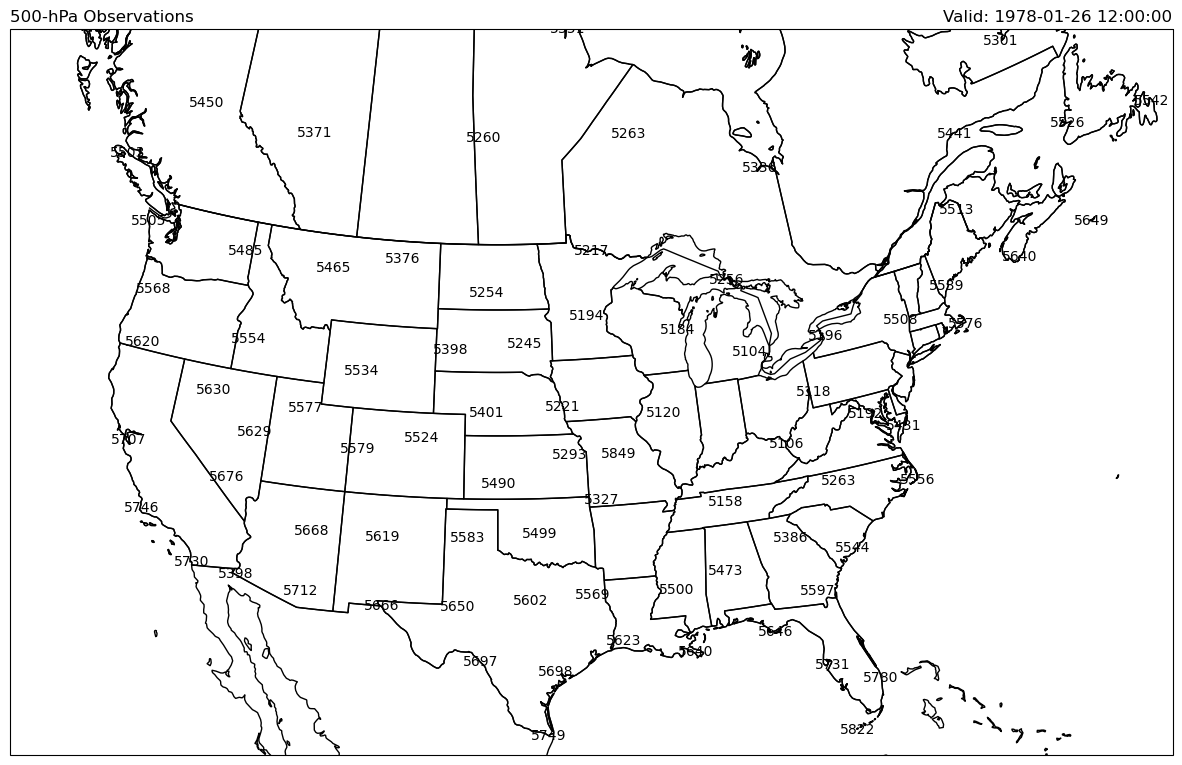

In [8]:
plt.figure(1, figsize=(15, 13))
ax = plt.subplot(111, projection=ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
ax.set_extent([-125, -65, 25, 55], ccrs.PlateCarree())

# Set up station object using lat/lon info from our Obs
station = StationPlot(ax, data_500.longitude, data_500.latitude, clip_on=True,
                      transform=ccrs.PlateCarree())

# Plot the Geopotnential Height values at the center location
station.plot_parameter('C', data_500.height)

# Add Geographic Features
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Add titles
plt.title(f'500-hPa Observations', loc='left')
plt.title(f'Valid: {date}', loc='right')

plt.show()

## Creating a Grid Interploation
With the above created image we could draw contours of geopotential height by hand to create an interpolation or we can generate a grid, have the computer do an interpolation of the observations, and then have the computer draw some contours. So let's try that out...

*But what types of interpolation could we use?*

There are a number of different interpolation methods that are available in the `interpolate_to_grid` function available from MetPy. Some of them are historic to meteorology (e.g., `'cressman'`, `'barnes'`) and others are common interpolation methods from mathematics/statistics (e.g., `'linear'`, '`cubic'`, `'rbf'`). Depending on which type of interpolation method you use, there might be additional parameters that can be set to refine the output from the interpolation.

*What else do I need to set?*

The other key element to set at minimum is the `hres` parameter, which dictates the spacing between grid points in the gridded dataset. This parameter should be set according to the units of your x and y values. If using lat/lon directly, then the units are degrees. If you are in some cartesian or projected space, the units are likely to be in meters or kilometers.

In [18]:
# Generate interpolated grid
gridx, gridy, grid_hght = interpolate_to_grid(data_500.longitude, data_500.latitude, data_500.height,
                                              interp_type='rbf', hres=1)

# Smooth the grid using a MetPy function
grid_hght_smooth = mpcalc.smooth_n_point(grid_hght, 9, 3)

In [19]:
grid_hght

array([[6384.96554115, 6366.03588654, 6347.47484162, ..., 5863.85832453,
        5864.92659263, 5866.        ],
       [6361.6560354 , 6342.62122457, 6323.95040891, ..., 5862.97806973,
        5867.4008676 , 5879.46113387],
       [6338.48781504, 6319.35017363, 6300.57112835, ..., 5868.83352987,
        5877.57248155, 5892.98776393],
       ...,
       [5529.76937082, 5508.90637001, 5489.26500385, ..., 6881.15442764,
        6901.35370739, 6921.83071553],
       [5548.27857101, 5527.31197397, 5507.49263164, ..., 6899.38346714,
        6919.59222818, 6940.07457637],
       [5567.22342612, 5546.20729393, 5526.2809543 , ..., 6917.68895609,
        6937.90671963, 6958.39405051]])

## Add contours to Observations
Use the new interpolated grid to plot contours using Matplotlib and add to the map of our observations.

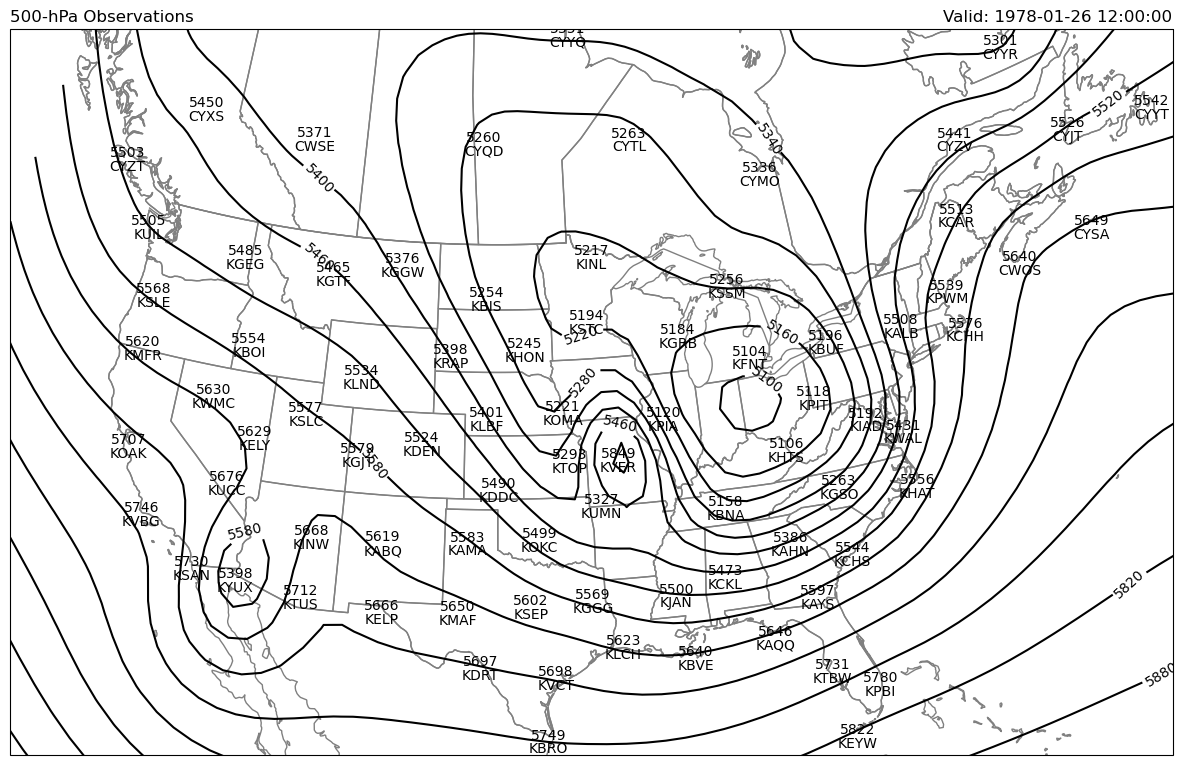

In [22]:
plt.figure(1, figsize=(15, 13))
ax = plt.subplot(111, projection=ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
ax.set_extent([-125, -65, 25, 55], ccrs.PlateCarree())

station = StationPlot(ax, data_500.longitude, data_500.latitude, transform=ccrs.PlateCarree(), clip_on=True)

station.plot_parameter('C', data_500.height)
station.plot_text('S', data_500.station)

# Add contours of interpolated geopotential heights
cs = ax.contour(gridx, gridy, grid_hght_smooth, np.arange(0, 10000, 60),
                colors='black', transform=ccrs.PlateCarree())
plt.clabel(cs)

# Add Geographic Features
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='grey')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='grey')
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='grey')

# Add titles
plt.title(f'500-hPa Observations', loc='left')
plt.title(f'Valid: {date}', loc='right')


plt.show()

# Bad Observations
When conducting our interpolation on raw observations, there could be bad (or misplaced) data points that greatly impact the interpolation and resulting contour analysis. Using data from 26 January 1978 at 12 UTC there are two observations that don't seem to fit.
1. Over central Misouri there is a misplaced station 'KVER' that should be removed
2. In Arizona, the Yuma sounding seems to have a wrong value for the 500-hPa geopotential height

So let's work to remove those data points and re-do our analysis.

In [23]:
# QC Data
data_500

,pressure,height,temperature,dewpoint,direction,speed,station,time,u_wind,v_wind,latitude,longitude
233,500.0,5640.0,-11.6,-17.0,228.0,NaN,CWOS,1978-01-26 12:00:00,NaN,NaN,43.72,-65.25
277,500.0,5371.0,-31.3,-46.7,319.0,NaN,CWSE,1978-01-26 12:00:00,NaN,NaN,53.53,-114.08
318,500.0,5467.0,-30.3,-39.2,115.0,NaN,CYBK,1978-01-26 12:00:00,NaN,NaN,64.28,-96.07
360,500.0,5450.0,-28.2,-41.6,235.0,NaN,CYCB,1978-01-26 12:00:00,NaN,NaN,69.08,-105.12
411,500.0,5311.0,-32.2,-41.2,272.0,NaN,CYEU,1978-01-26 12:00:00,NaN,NaN,80.0,-85.82
...,...,...,...,...,...,...,...,...,...,...,...,...
5676,500.0,5698.0,-14.6,-33.0,272.0,54.0,KVCT,1978-01-26 12:00:00,53.967105,-1.884573,28.87,-96.93
5712,500.0,5849.0,-7.2,-26.8,230.0,10.0,KVER,1978-01-26 12:00:00,7.660444,6.427876,38.95,-92.68
5748,500.0,5431.0,-11.3,-30.3,209.0,112.0,KWAL,1978-01-26 12:00:00,54.298677,97.957407,37.93,-75.47
5784,500.0,5630.0,-20.9,-22.4,287.0,46.0,KWMC,1978-01-26 12:00:00,43.990019,-13.449098,40.9,-117.8


In [24]:
data_500 = data_500[(df.station != 'KVER') & (df.station != 'KYUX')]

/var/folders/fp/_l45s1m93s5009vb713pyg580000gn/T/ipykernel_73915/1052634290.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_500 = data_500[(df.station != 'KVER') & (df.station != 'KYUX')]


In [29]:
gridx, gridy, grid_hght = interpolate_to_grid(data_500.longitude, data_500.latitude, data_500.height,
                                              interp_type='rbf', hres=1)
grid_hght_smooth = mpcalc.smooth_n_point(grid_hght, 9, 3)

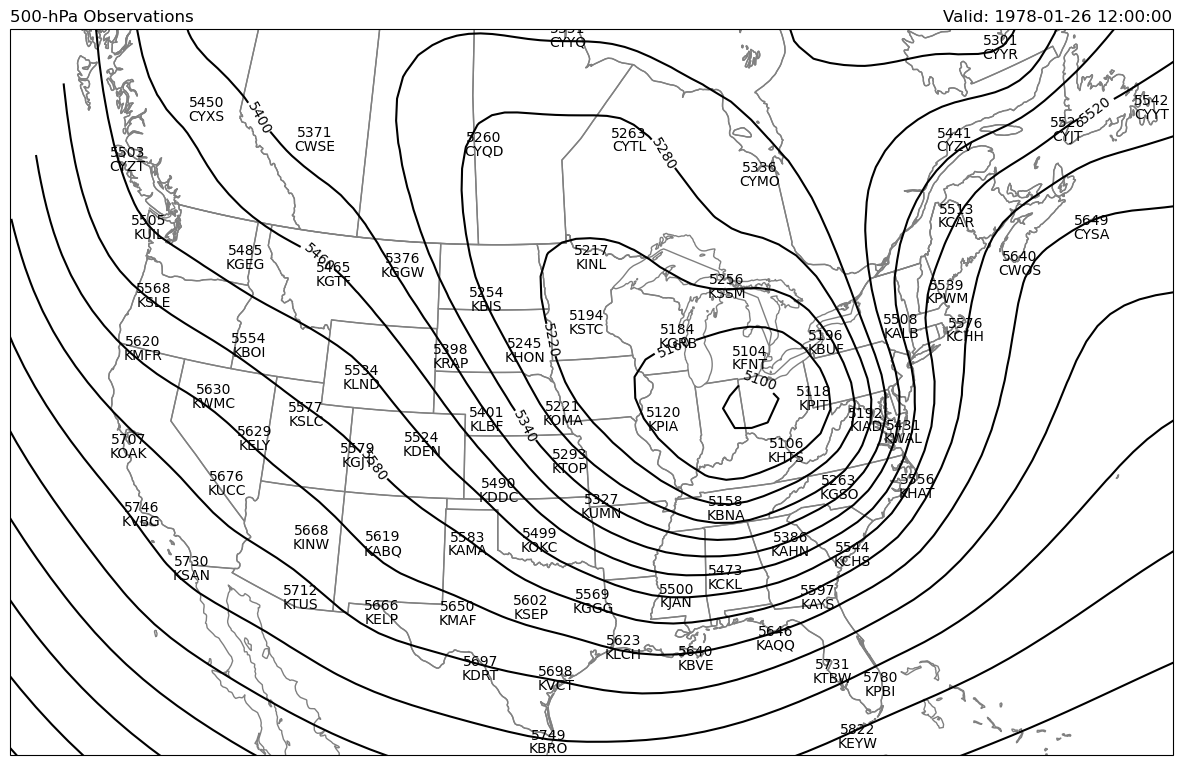

In [30]:
plt.figure(2, figsize=(15, 13))
ax = plt.subplot(111, projection=ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
ax.set_extent([-125, -65, 25, 55], ccrs.PlateCarree())

station = StationPlot(ax, data_500.longitude, data_500.latitude, transform=ccrs.PlateCarree(), clip_on=True)

station.plot_parameter('C', data_500.height)
station.plot_text('S', data_500.station)

# Add contours of interpolated geopotential heights
cs = ax.contour(gridx, gridy, grid_hght_smooth, np.arange(0, 10000, 60),
                colors='black', transform=ccrs.PlateCarree())
plt.clabel(cs)

# Add Geographic Features
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='grey')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='grey')
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='grey')

# Add titles
plt.title(f'500-hPa Observations', loc='left')
plt.title(f'Valid: {date}', loc='right')


plt.show()

## Plot UPA Station Model with Contours
Here we plot the full upperair station model with our interpolated grid contours. Looks like our interpolation did a good job where we have observations of representing the geopotential heights as the winds indicate the geostrophic balance is obtained.

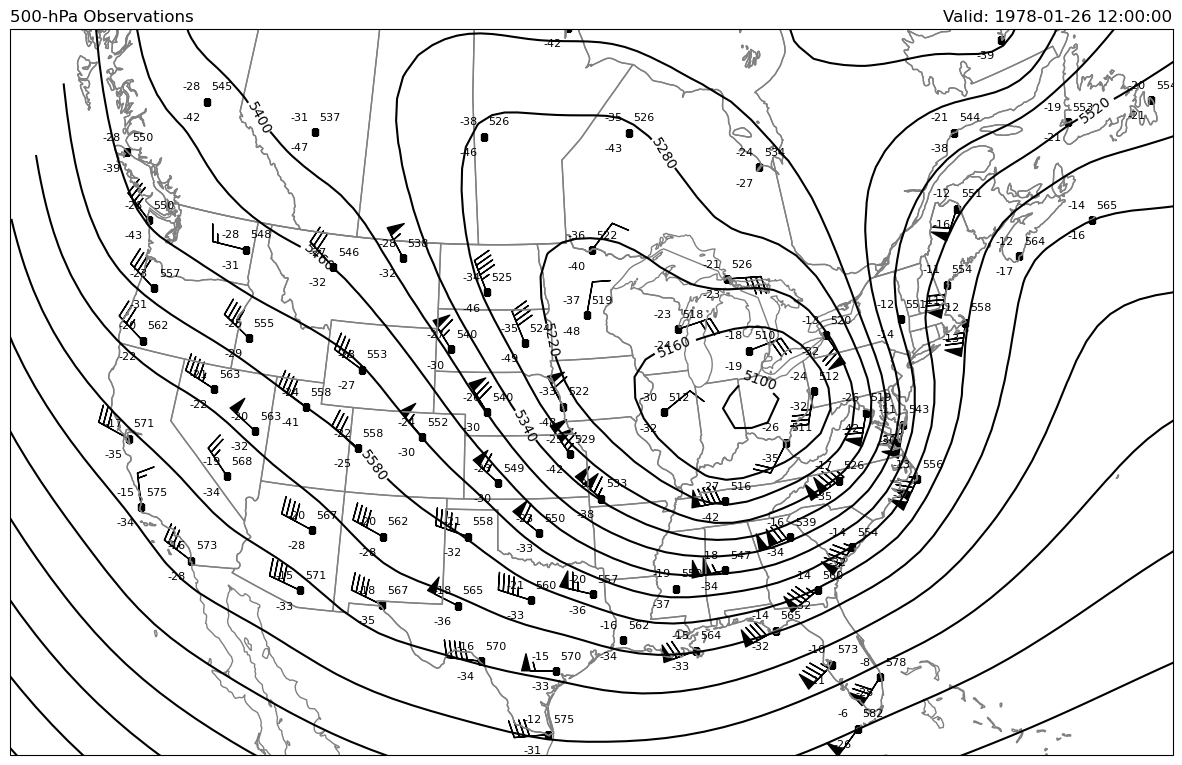

In [38]:
plt.figure(3, figsize=(15, 13))
ax = plt.subplot(111, projection=ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
ax.set_extent([-125, -65, 25, 55], ccrs.PlateCarree())

station = StationPlot(ax, data_500.longitude, data_500.latitude, fontsize=8, spacing=11, transform=ccrs.PlateCarree(), clip_on=True)

# Add all station data around obs point
station.plot_parameter('NE', data_500.height/10, formatter='.0f')
station.plot_parameter('NW', data_500.temperature)
station.plot_parameter('SW', data_500.dewpoint)

station.plot_barb(data_500.u_wind, data_500.v_wind, length=7, pivot='tip')

ax.scatter(data_500.longitude, data_500.latitude, s=15, marker='s', color='black', transform=ccrs.PlateCarree())

cs = ax.contour(gridx, gridy, grid_hght_smooth, np.arange(0, 10000, 60), colors='black', transform=ccrs.PlateCarree())
plt.clabel(cs)

# Add Geographic Features
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='grey')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='grey')
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='grey')

# Add titles
plt.title(f'500-hPa Observations', loc='left')
plt.title(f'Valid: {date}', loc='right')


plt.show()